# 04 - Clustering

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping

import os

from models.X_RCC import XRCC, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [2]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 2

learning_rate   = 2
min_len         = 30
mode            = 'single'
starting_bp     = [165, 264]

overwrite_results = True

In [3]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

Results already stored! - Overwriting


In [4]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/2m_temperature/temperature_1980_2011_15dd.nc').var167.load()
    dataset_tp = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/total_precipitation/precipitation_1980_2011_15dd.nc').tp.load()

    dataset_tp['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

    clustering_params = {
        'iters': n_iters,
        'n_seas': n_seasons,
        'learning_rate': learning_rate,
        'min_len': min_len,
        'mode': mode,
        'starting_bp': starting_bp,
    }

    result = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

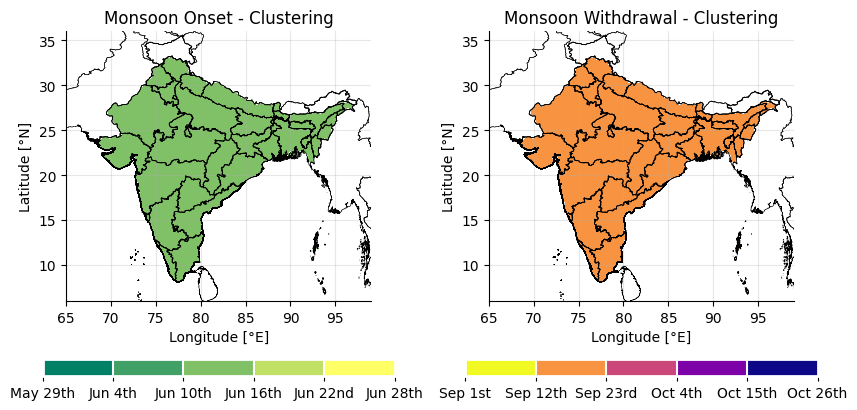

In [5]:
# Load country boundary data
mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
result_plot.rio.write_crs("epsg:4326", inplace=True)
result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)


plot_seasons_bk_results( result_plot, figsize=(10,5), cmaps=['summer', 'plasma_r'],
                         lims=[[150,180],[245,300]], titles=['Monsoon Onset - Clustering', 'Monsoon Withdrawal - Clustering'],
                         country_boundary=country_boundary, world_boundary=world_boundary)

plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [6]:
if not os.path.exists(results_path_file) or overwrite_results:
    
    result.attrs=dict(
            Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
            Parameters=(

                f"Number of seasons: {n_seasons}",
                f"Number of iterations: {n_iters}",
                f"Learning rate: {learning_rate}",
                f"Minimum length of seasons: {min_len}",
                f"Clustering mode: {mode}",
                f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
            )
        )

    result.to_netcdf(results_path_file)

In [7]:
# datasets = [dataset_tp, dataset_t2m]  # List of xarray DataArrays

# tot = []
# for j, st in zip([2,4], [[165, 264],[80, 165, 264, 300]]):
#     clustering_params = {
#         'iters': 100,
#         'learning_rate': 10,
#         'min_len': 30,
#         'mode': 'single',
#         'starting_bp': st,  # Optional, if starting_bp is used
#         'n_seas' : j
#     }

#     silhouette_scores = XRCC_silhouette(datasets, **clustering_params)
#     tot.append(silhouette_scores.assign_coords(n_seasons=j))

# tota = xr.concat(tot, dim='n_seasons')


In [8]:
# plot = tota.plot(col='n_seasons', col_wrap=2, vmin=0, vmax=0.25, levels=7, add_colorbar=False, figsize=(7,3))

# standard_format( plot,
#                  country_boundary   = country_boundary,
#                  world_boundary     = world_boundary,
#                  custom_cbar        = True
#                 )

In [9]:
# combined_data_array_filled = tota.fillna(-np.inf)
# max_n_seasons_idx = combined_data_array_filled.argmax(dim='n_seasons')
# max_n_seasons = tota['n_seasons'][max_n_seasons_idx]

# # Crea un mask per individuare dove entrambi i n_seasons sono NaN
# nan_mask = np.isnan(tota.sel(n_seasons=2)) & np.isnan(tota.sel(n_seasons=4))

# # Rimuovere i NaN dai risultati finali usando il mask
# max_n_seasons = max_n_seasons.where(~nan_mask)

In [10]:
# plot = max_n_seasons.plot(vmin=1, vmax=5, levels=3, add_colorbar=False, figsize=(5,5))

# standard_format_single( plot,
#                         country_boundary   = country_boundary,
#                         # world_boundary     = world_boundary,
#                         custom_cbar        = True
#                         )
# plot.colorbar.set_ticks(ticks=[2,4], labels=[2,4])